# The White Shark Cafe - Spectral Analysis

This notebook analyzes CROCO simulations for the manuscript (in preparation) "Annual migration of white sharks to the Eastern Subtropical Mode Water formation region" by Thomas, Wenegrat, and Block.



In [158]:
%load_ext autoreload
%autoreload 2

import time

import xarray as xr
import xgcm
import numpy as np
import xroms
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from glob import glob
from dask.diagnostics import ProgressBar
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import cmocean as cm

import pyspec.spectrum as spec

import sys
sys.path.append("../src/")
import spectral_tools as st

import scipy.integrate as integrate

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
chunks={'time':1, 's_rho':10, 's_w':10}
fileprefix = '/data/pacific/jacob/WHITESHARKCAFE/Data/MSHARK_D3/'
# Load History Files
files = sorted(glob(fileprefix+'mshark_his.*.nc'))


chunks={'time':1, 's_rho':10, 's_w':10}
#ds = xroms.open_mfnetcdf(files, chunks, xrargs={'combine':'nested'})
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks)

ds = ds.rename(time='ocean_time')
ds, grid = xroms.roms_dataset(ds, Vtransform=2)
    
ds['yearday'] = np.mod(ds.scrum_time/86400, 360)

# Load PV diagnostics
files = sorted(glob(fileprefix+'mshark_diapv*.nc'))
dspv = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal')
dspv = dspv.rename(time='ocean_time')
dspv['yearday'] = np.mod(dspv.scrum_time/86400, 360)

# Load Momentum diagnostics
files = sorted(glob(fileprefix+'mshark_diaM*.nc'))
dsm = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal')
dsm = dsm.rename(time='ocean_time')
dsm['yearday'] = np.mod(dsm.scrum_time/86400, 360)

# Truncate to the correct year period 
dayslice = slice(2*30, 2*30+12*30) # Sept 1 (yearday through Sept 1st
ds = ds.isel(ocean_time=dayslice)
dspv = dspv.isel(ocean_time=dayslice)
dayslice = slice(11,11+72 )
dsm = dsm.isel(ocean_time=dayslice)

ds = ds.swap_dims({'ocean_time':'yearday'})
dsm = dsm.swap_dims({'ocean_time':'yearday'})

In [3]:
# Some times and variables

a = 6371315.0 # CROCO Earth radius
m_per_deg = 2*np.pi*a/360

# Season ranges
# XXX - ARE SLICES INCLUSIVE?
SON = slice(240, 240+3*30)
DJF = list(range(330, 360)) + list(range(0,60))
DJFm = list(range(330, 360, 5)) + list(range(0,60, 5)) # hack for the 5 day mom outputs since I'm using a range here (rather than slice)
MAM = slice(60, 60 + 3*30)
JJA = slice(150, 150 + 3*30-1)
JJAm = slice(150, 235)

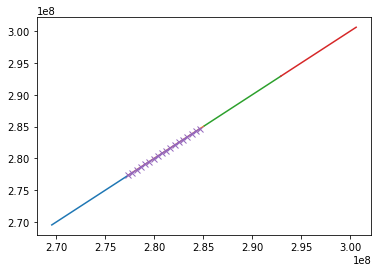

In [4]:
# Make a quick plot to verify the season decomposition from above
plt.plot(ds.ocean_time.sel(yearday=SON), ds.ocean_time.sel(yearday=SON))
plt.plot(ds.ocean_time.sel(yearday=DJF), ds.ocean_time.sel(yearday=DJF))
plt.plot(ds.ocean_time.sel(yearday=MAM), ds.ocean_time.sel(yearday=MAM))
plt.plot(ds.ocean_time.sel(yearday=JJA), ds.ocean_time.sel(yearday=JJA))

plt.plot(dsm.ocean_time.sel(yearday=DJFm), dsm.ocean_time.sel(yearday=DJFm), marker='x', )

# Interpolation

Note that before calculation variables must be interpolated to linear Cartesian grid. 

- We restrict consideration to grid cells not affected by the sponge layer (width=10 grid points).
- New grid is uniform 1.5 km (very close to original grid)

In [166]:
dx = 1.5e3
dy = dx

x = ds.dx.cumsum('xi_rho')
y = ds.dy.cumsum('eta_rho')

sponge = 10
# Calculate the length of a box fully contained in grid in lat
trimlats = ds.lat_rho[sponge:-sponge,sponge:-sponge]
bottom_lat = np.max(trimlats[0,:])
top_lat = np.min(trimlats[-1,:])
deltalat = top_lat - bottom_lat
ydistance = deltalat*m_per_deg
yi = np.arange(0, ydistance, dy)
# Calculate the length of a box fully contained in grid in lon
trimlons = ds.lon_rho[sponge:-sponge,sponge:-sponge]
deltalons = trimlons-trimlons[:,0]
distance = deltalons*m_per_deg*np.cos(trimlats*np.pi/180)
latind = np.argmin(distance[:,-1].values) # find the eta index of the least distance in domain
xi = np.arange(0, distance[latind,-1].values, dx)

nx = xi.size
ny = yi.size
lonlim = np.linspace(trimlons[0,0], trimlons[-1,0], nx)
XI, YI = np.meshgrid(yi, xi)

# Here I convert from the Cartesian grid back to the lat/lon for use with xesmf regridding
LATI = YI/m_per_deg + bottom_lat.values
#LONI = XI/(m_per_deg*np.cos(LATI*np.pi/180)) + ds.lon_rho[:,0].values[sponge:-sponge,np.newaxis]
LONI = XI/(m_per_deg*np.cos(LATI*np.pi/180)) + lonlim[:,np.newaxis]


# The below code finds the index of the depth limit for spectral calculations
zmeans = ds.z_rho0.mean(['eta_rho', 'xi_rho']).values
zind = np.argmin(np.abs(zmeans+100))

In [73]:
# Do the actual regridding
# Some editable parameters
lons = LONI
lats = LATI
which='grid'
zind= -1 # speeds up computation for testing (should be commented out for real analysis)

# Zonal component
var = ds.u[:,zind:,:,:]
ui, _ = st.regrid(var, lons, lats, which)

# Meridional component
var = ds.v[:,zind:,:,:]
vi, _ = st.regrid(var, lons, lats, which)

SyntaxError: invalid syntax (<ipython-input-73-6faee69b721b>, line 14)

## Calculate Isotropic KE Spectra by Season

In [9]:
####################################
############# SON ##################
####################################

tic = time.perf_counter()
uvar = ui.sel(yearday=SON)[:,:,1:,1:]
vvar = vi.sel(yearday=SON)[:,:,1:,1:]
specke_SON, kit = st.calculateKEspec(uvar, vvar, dx, dy)
specke_SON.name = 'SON'
print(time.perf_counter()-tic)

####################################
############# DJF ##################
####################################

tic = time.perf_counter()
uvar = ui.sel(yearday=DJF)[:,:,1:,1:]
vvar = vi.sel(yearday=DJF)[:,:,1:,1:]
specke_DJF, kit = st.calculateKEspec(uvar, vvar, dx, dy)
specke_DJF.name = 'DJF'
print(time.perf_counter()-tic)

####################################
############# MAM ##################
####################################

tic = time.perf_counter()
uvar = ui.sel(yearday=MAM)[:,:,1:,1:]
vvar = vi.sel(yearday=MAM)[:,:,1:,1:]
specke_MAM, kit = st.calculateKEspec(uvar, vvar, dx, dy)
specke_MAM.name = 'MAM'
print(time.perf_counter()-tic)

####################################
############# JJA ##################
####################################

tic = time.perf_counter()
uvar = ui.sel(yearday=JJA)[:,:,1:,1:]
vvar = vi.sel(yearday=JJA)[:,:,1:,1:]
specke_JJA, ki = st.calculateKEspec(uvar, vvar, dx, dy)
specke_JJA.name ='JJA'
print(time.perf_counter()-tic)

160.2767669595778
200.85270463395864
206.16611752379686
200.86490450240672


## WRITE KE SPEC TO DISK

In [29]:
savenc = False
if savenc:
    dsspec = xr.merge([specke_SON, specke_DJF, specke_MAM, specke_JJA])
    dsspec['ki'] = ki
    dsspec.to_netcdf('../Data/Processed/ke_spec.nc')

## SPECTRAL ENERGY FLUX

The spectral energy flux is defined as,
$-\hat{\boldsymbol{u}}^* \cdot \widehat{\boldsymbol{u}\cdot\nabla\boldsymbol{u}}$

Thus, expanding the term gives,
$-\hat{u}^*\widehat{uu_x} - \hat{u}^*\widehat{vu_y} -\hat{v}^*\widehat{uv_x} - \hat{v}^*\widehat{vv_y}$.

In [119]:
def calculateCoSpecs(uvar, advvar, dx, dy):
    def fluxfunc(u, adv, dx,dy):
        spec2d = spec.CO_TWODimensional_spec(adv,u, dx,dy)
        return spec2d.ispec
    
    out_ef = xr.apply_ufunc(fluxfunc, 
               uvar.load(),
               advvar.load(),
               dx, 
               dy,
               input_core_dims=[['y', 'x'],['y','x'],[],[]],
               output_core_dims=[['ki']],
               #exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)
    
    keflux = out_ef.mean(['yearday', 's_rho'])
    # One hacky last call to spectrum to get the frequencies...
    return keflux

def ProcessFluxes(YDS, ds, dsm):
    # Get the xadv yeardays (5 day output)
    yds = dsm.yearday.sel(yearday=YDS).values
    # Use them to get the corresponding velocities snapshots
    u = ds.u.sel(yearday=yds)[:,zind:,:,:]
    v = ds.v.sel(yearday=yds)[:,zind:,:,:]
    # Get the advection components
    u_xadv = dsm.u_xadv.sel(yearday=YDS)[:,zind:,:,:]
    u_yadv = dsm.u_yadv.sel(yearday=YDS)[:,zind:,:,:]
    v_xadv = dsm.v_xadv.sel(yearday=YDS)[:,zind:,:,:]
    v_yadv = dsm.v_yadv.sel(yearday=YDS)[:,zind:,:,:]

    # Everything needs to be regridded for processing
    # Do the actual regridding
    print('regridding')
    # zonal adv
    ui, regridder = st.regrid(u, lons, lats, which)
    ui = ui[:,:,1:,1:]
    u_xadvi = regridder(u_xadv)
    u_xadvi = u_xadvi[:,:,1:,1:]
    u_yadvi = regridder(u_yadv)
    u_yadvi = u_yadvi[:,:,1:,1:]

    # meridional adv
    vi, regridder = st.regrid(v, lons, lats, which)
    vi = vi[:,:,1:,1:]
    print(vi.shape)
    v_xadvi = regridder(v_xadv)
    v_xadvi = v_xadvi[:,:,1:,1:]
    v_yadvi = regridder(v_yadv)
    v_yadvi = v_yadvi[:,:,1:,1:]
    
    # Calculate cospectra
    print('calculating cospectra')
    u_x_co = calculateCoSpecs(ui, u_xadvi, dx, dy)
    u_y_co = calculateCoSpecs(ui, u_yadvi, dx, dy)
    v_x_co = calculateCoSpecs(vi, v_xadvi, dx, dy)
    v_y_co = calculateCoSpecs(vi, v_yadvi, dx, dy)
    co_specs = -u_x_co - u_y_co - v_x_co - v_y_co
    return co_specs

In [149]:
# Parameters
lons = LONI
lats = LATI
which='grid'
#zind= -2 # speeds up computation for testing (should be commented out for real analysis)

####################################
############# SON ##################
####################################
print("SON")
co_specs_SON = ProcessFluxes(SON, ds, dsm)
spec_flux_SON = integrate.cumtrapz(co_specs_SON, x=ki, initial=0)

####################################
############# DJF ##################
####################################
print("DJF")
co_specs_DJF = ProcessFluxes(DJFm, ds, dsm)
spec_flux_DJF = integrate.cumtrapz(co_specs_DJF, x=ki, initial=0)

####################################
############# MAM ##################
####################################
print("MAM")
co_specs_MAM = ProcessFluxes(MAM, ds, dsm)
spec_flux_MAM = integrate.cumtrapz(co_specs_MAM, x=ki, initial=0)

####################################
############# JJA ##################
####################################
print("JJA")
co_specs_JJA = ProcessFluxes(JJAm, ds, dsm)
spec_flux_JJA = integrate.cumtrapz(co_specs_JJA, x=ki, initial=0)

JJA
regridding


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/dask/array/core.py:380: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` paramet

(18, 2, 876, 870)


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


calculating cospectra


NameError: name 'co_specs_JJAm' is not defined

In [150]:
spec_flux_JJA = integrate.cumtrapz(co_specs_JJA, x=ki, initial=0)

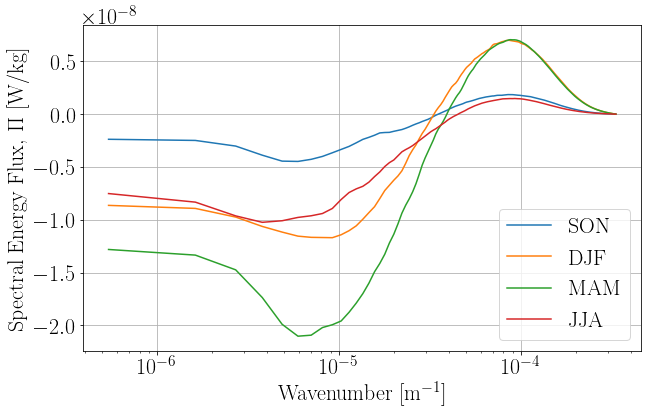

In [163]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)

ax.semilogx(ki, (spec_flux_SON-spec_flux_SON[-1]), label='SON')
ax.semilogx(ki, (spec_flux_DJF-spec_flux_DJF[-1]), label='DJF')
ax.semilogx(ki, (spec_flux_MAM-spec_flux_MAM[-1]), label='MAM')
ax.semilogx(ki, (spec_flux_JJA-spec_flux_JJA[-1]), label='JJA')

plt.grid()
plt.legend()
ax.set_xlabel(r"Wavenumber [m$^{-1}$]")
ax.set_ylabel(r"Spectral Energy Flux, $\Pi$ [W/kg]")
#plt.savefig('../Figures/SpecFlux.pdf')

In [161]:
1/(8*1.5e3)

8.333333333333333e-05

In [42]:
dsm

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 902, eta_v: 901, s_rho: 80, s_w: 81, xi_rho: 902, xi_u: 901, yearday: 72)
Coordinates:
  * eta_rho     (eta_rho) float64 1.0 2.0 3.0 4.0 ... 899.0 900.0 901.0 902.0
  * eta_v       (eta_v) float64 1.5 2.5 3.5 4.5 5.5 ... 898.5 899.5 900.5 901.5
  * s_rho       (s_rho) float64 -0.9937 -0.9812 -0.9688 ... -0.01875 -0.00625
  * xi_rho      (xi_rho) float64 1.0 2.0 3.0 4.0 5.0 ... 899.0 900.0 901.0 902.0
  * xi_u        (xi_u) float64 1.5 2.5 3.5 4.5 5.5 ... 898.5 899.5 900.5 901.5
  * s_w         (s_w) float32 -1.0 -0.9875 -0.975 -0.9625 ... -0.025 -0.0125 0.0
    lon_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    ocean_time  (yearday) float64 2.696e+08 2.7e+08 ... 2.998e+08 3.002e+08
  * yearday     (yearday) float64 240.0 245.0 250.0 255.0 ... 225.0 230.0 235.0
Dimensions without coordinates: auxil
Data variables:
    spherical   |S1 ...
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(80,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(81,), meta=np.ndarray>
    Cs_r        (s_rho) float32 dask.array<chunksize=(80,), meta=np.ndarray>
    Cs_w        (s_w) float32 dask.array<chunksize=(81,), meta=np.ndarray>
    hc          float32 ...
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float32 dask.array<chunksize=(902, 901), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float32 dask.array<chunksize=(902, 901), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float32 dask.array<chunksize=(901, 902), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float32 dask.array<chunksize=(901, 902), meta=np.ndarray>
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    mask_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    time_step   (yearday, auxil) int32 dask.array<chunksize=(9, 4), meta=np.ndarray>
    scrum_time  (yearday) float32 dask.array<chunksize=(9,), meta=np.ndarray>
    u_xadv      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_yadv      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_vadv      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_cor       (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_prsgrd    (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_hmix      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_hdiff     (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_vmix      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_nudg      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_rate      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    v_xadv      (yearday, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(9, 80, 901, 902), meta=np.ndarray>
    v_yadv      (yearday, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(9, 80, 901, 902), meta=np.ndarray>
    v_vadv      (yearday, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(9, 80, 901, 902), meta=np.ndarray>
    v

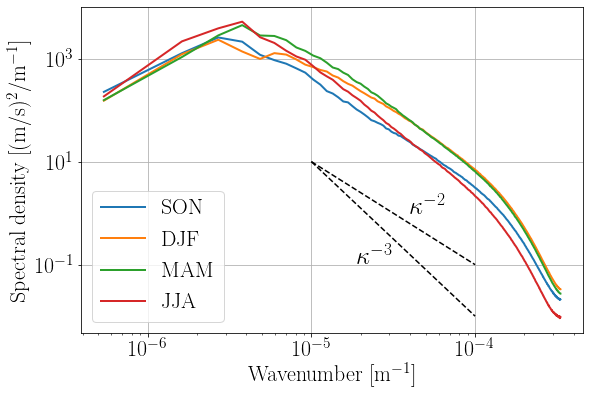

In [165]:
# Plot Spectra by Month
k3 = np.array([1e-5,1e-4])
E3 = 1/k3**3/1e14
E2 = 1/k3**2; E2 = E2/E2[0]*E3[0]


fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(111)

#plt.loglog(spec2d_u.ki,np.mean(esm[[11,0, 1],:], axis=0), label='DJF', linewidth=2) #DJF
#plt.loglog(spec2d_u.ki,np.mean(esm[[2, 3, 4],:], axis=0), label='MAM', linewidth=2) #MAM
#plt.loglog(spec2d_u.ki,np.mean(esm[[5, 6, 7],:], axis=0), label='JJA', linewidth=2) #DJF
plt.loglog(ki,specke_SON, label='SON', linewidth=2) #SON
plt.loglog(ki,specke_DJF, label='DJF', linewidth=2) #DJF
plt.loglog(ki,specke_MAM, label='MAM', linewidth=2) #MAM
plt.loglog(ki,specke_JJA, label='JJA', linewidth=2) #JJA

#plt.plot(ki,test, label='SON', linewidth=2) #DJF

plt.loglog(k3,E3,'k--')
plt.loglog(k3,E2,'k--')
plt.text(4.e-5,1e-0,r'$\kappa^{-2}$',fontsize=25)
plt.text(1.9e-5,1.05e-1,r'$\kappa^{-3}$',fontsize=25)

plt.grid()
plt.legend()
ax.set_xlabel(r"Wavenumber [m$^{-1}$]")
ax.set_ylabel(r"Spectral density [(m/s)$^2$/m$^{-1}$]")
#plt.savefig('../Figures/KESpectra.pdf', bbox_inches='tight')

In [88]:
def testfunc(uv, dx,dy):
    print('howdy')
    spec2d = spec.TWODimensional_spec(uv, dx,dy)
    return spec2d.ispec

In [85]:
zlim = -1

uvar = ui[0:1,zlim:,1:,1:]#.copy(deep=True)
vvar = vi[0:10,zlim:,1:,1:]#.copy(deep=True)
#uvar = ds.u[0:1,zlim:,:,1:].copy(deep=True)
#vvar = ds.v[0:1,zlim:,1:,:].copy(deep=True)
#vvar = uvar
tic = time.perf_counter()


out_u = xr.apply_ufunc(testfunc, 
               uvar.load(),
               dx, 
               dy,
               #dask='allowed',
               input_core_dims=[['y', 'x'],[],[]],
               #input_core_dims=[['eta_rho','xi_u'],[],[]],
               #output_sizes={'ki':2,},
               output_core_dims=[['ki']],
               #exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)
out_v = xr.apply_ufunc(testfunc, 
               vvar.load(),
               dx, 
               dy,
               #dask='allowed',
               input_core_dims=[['y', 'x'],[],[]],
               #input_core_dims=[['eta_v','xi_rho'],[],[]],
               output_core_dims=[['ki']],
               #exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)

test = (0.5*(out_u + out_v)).mean(['yearday', 's_rho'])
print(time.perf_counter()-tic)

howdy
(876, 870)
howdy
(876, 870)


ValueError: could not broadcast input array from shape (2,308) into shape (308)

In [87]:
out_u

<xarray.DataArray 'u' (yearday: 1, s_rho: 1, ki: 2, k2: 308)>
array([[[[9.85316185e+01, 2.26041696e+03, 4.99114759e+03,
          2.11917849e+03, 1.31653264e+03, 1.49825500e+03,
          1.22138257e+03, 8.76634037e+02, 5.96595590e+02,
          5.06774837e+02, 2.71962735e+02, 2.48211150e+02,
          2.49174733e+02, 1.88941907e+02, 1.76259403e+02,
          1.55157167e+02, 1.28819329e+02, 1.01271651e+02,
          1.02281592e+02, 6.04351056e+01, 5.14496893e+01,
          5.36709395e+01, 5.09389986e+01, 5.92759000e+01,
          3.75956553e+01, 3.12694132e+01, 2.76345465e+01,
          2.79572791e+01, 3.36867016e+01, 2.47955687e+01,
          2.27112638e+01, 2.72914732e+01, 2.97205854e+01,
          3.24005026e+01, 2.59418928e+01, 2.72784208e+01,
          2.60274686e+01, 1.61673200e+01, 1.43081464e+01,
          1.55400651e+01, 1.39887279e+01, 1.21715286e+01,
          1.20189583e+01, 1.37370631e+01, 1.00588030e+01,
          1.02366716e+01, 9.90827739e+00, 1.02811788e+01,
          1.01749712e+01, 8.54294228e+00, 7.74412928e+00,
          8.40797081e+00, 8.06908504e+00, 7.44304388e+00,
          7.29560228e+00, 8.15911630e+00, 7.32096533e+00,
          6.76054023e+00, 4.83334904e+00, 5.32284125e+00,
...
          2.69455925e-04, 2.70535909e-04, 2.71615893e-04,
          2.72695876e-04, 2.73775860e-04, 2.74855844e-04,
          2.75935827e-04, 2.77015811e-04, 2.78095795e-04,
          2.79175778e-04, 2.80255762e-04, 2.81335746e-04,
          2.82415729e-04, 2.83495713e-04, 2.84575697e-04,
          2.85655680e-04, 2.86735664e-04, 2.87815648e-04,
          2.88895631e-04, 2.89975615e-04, 2.91055599e-04,
          2.92135582e-04, 2.93215566e-04, 2.94295550e-04,
          2.95375533e-04, 2.96455517e-04, 2.97535501e-04,
          2.98615484e-04, 2.99695468e-04, 3.00775452e-04,
          3.01855435e-04, 3.02935419e-04, 3.04015403e-04,
          3.05095386e-04, 3.06175370e-04, 3.07255354e-04,
          3.08335337e-04, 3.09415321e-04, 3.10495305e-04,
          3.11575288e-04, 3.12655272e-04, 3.13735256e-04,
          3.14815239e-04, 3.15895223e-04, 3.16975207e-04,
          3.18055190e-04, 3.19135174e-04, 3.20215158e-04,
          3.21295141e-04, 3.22375125e-04, 3.23455109e-04,
          3.24535092e-04, 3.25615076e-04, 3.26695060e-04,
          3.27775043e-04, 3.28855027e-04, 3.29935011e-04,
          3.31014994e-04, 3.32094978e-04]]]])
Coordinates:
  * s_rho       (s_rho) float64 -0.00625
    ocean_time  (yearday) float64 2.696e+08
  * yearday     (yearday) float64 240.0
Dimensions without coordinates: ki, k2

In [91]:
# Calculate the isotropic spectrum
zlim = -2

uvar = ui[0:2,zlim:,1:,1:]#.copy(deep=True)
vvar = vi[0:2,zlim:,1:,1:]#.copy(deep=True)
# Note that here the duration in yearday and s_rho can be adjusted for testing purposes
#uvar = ui[0:2,zlim:,1:,1:].copy(deep=True)
#vvar = vi[0:2,zlim:,1:,1:].copy(deep=True)

#uvar = ds.u[0:1,zlim:,:,1:].copy(deep=True)
#vvar = ds.v[0:1,zlim:,1:,:].copy(deep=True)
#vvar = uvar
#uvar = ds.u[0:2,zlim:,2:,1:]
#vvar = ds.v[0:2,zlim:,1:,2:]
# This function outputs the isotropic energy spectrum (specke) and the wavenumber array (ki)
tic = time.perf_counter()
#specvec = np.vectorize(st.calculateKEspec(uvar, vvar, dy, dy))
#specke_SON, ki = st.calculateKEspec(uvar, vvar, dx, dy)

specke_SON, ki = st.calculateKEspec1(uvar.values, vvar.values, dx, dy)
test, kit = st.calculateKEspec(uvar, vvar, dx, dy)
#specke_SONv, ki = st.calculateKEspec1(vvar.values, dx, dy)
#spke = specvec(uvar, vvar, dx, dy)
#specke_SON = specke_SON+specke_SONv
print(time.perf_counter()-tic)

0
(876, 870)
(876, 870)
(876, 870)
(876, 870)
1
(876, 870)
(876, 870)
(876, 870)
(876, 870)
4
(876, 870)
(876, 870)
(876, 870)
(876, 870)
(876, 870)
(876, 870)
(876, 870)
(876, 870)
(876, 870)
17.993109283968806


(308,)

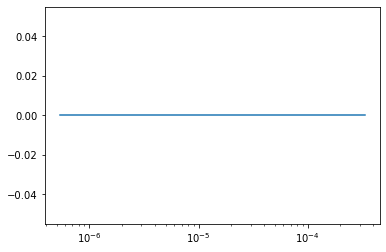

In [92]:
plt.semilogx(kit,(test-specke_SON))
#plt.plot(specke_SON)

In [362]:
#uvar = ui[0:2,zlim:,1:,1:]
#vvar = vi[0:2,zlim:,1:,1:]

tic = time.perf_counter()

out_u = xr.apply_ufunc(testfunc, 
               uvar.load(),
               dx, 
               dy,
               #dask='parallelized',
               input_core_dims=[['eta_rho','xi_u'],[],[]],
               output_core_dims=[['x']],
               exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)
out_v = xr.apply_ufunc(testfunc, 
               vvar.load(),
               dx, 
               dy,
               #dask='parallelized',
               input_core_dims=[['eta_v','xi_rho'],[],[]],
               output_core_dims=[['x']],
               exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)
test = (0.5*(out_u + out_v)).mean(['yearday', 's_rho'])
print(time.perf_counter()-tic)

(900, 900)
(900, 900)
(900, 900)
(900, 900)
(900, 900)
(900, 900)
(900, 900)
(900, 900)
7.127927582710981


In [203]:
uvar

<xarray.DataArray 'u' (yearday: 2, s_rho: 2, y: 876, x: 870)>
array([[[[-0.33512626, -0.3671963 , -0.39382912, ..., -0.14537163,
          -0.14453796, -0.14377456],
         [-0.37995932, -0.41441842, -0.43857466, ..., -0.1475029 ,
          -0.14658084, -0.14575853],
         [-0.43362899, -0.45786746, -0.47223427, ..., -0.14922176,
          -0.14824374, -0.14736697],
         ...,
         [-0.13588874, -0.1335527 , -0.13143356, ..., -0.00537884,
          -0.00513291, -0.0049206 ],
         [-0.13233905, -0.13001966, -0.12797374, ..., -0.0060124 ,
          -0.00586647, -0.00575475],
         [-0.128748  , -0.12646711, -0.12448392, ..., -0.00656942,
          -0.00660131, -0.00661003]],

        [[-0.36430303, -0.39805356, -0.42558772, ..., -0.15913472,
          -0.15831279, -0.15755807],
         [-0.41138015, -0.44707544, -0.47163701, ..., -0.16117816,
          -0.1602643 , -0.15944257],
         [-0.4667394 , -0.49133198, -0.50555026, ..., -0.16277912,
          -0.16180386, -0.16091571],
...
         [-0.11451543, -0.11343466, -0.11227752, ..., -0.00834329,
          -0.00830187, -0.00834663],
         [-0.10924254, -0.10851691, -0.10761607, ..., -0.00990824,
          -0.00994827, -0.01006172],
         [-0.10458029, -0.10427296, -0.10360633, ..., -0.0115242 ,
          -0.01173818, -0.01193688]],

        [[-0.32758904, -0.32960614, -0.33165031, ..., -0.10821359,
          -0.10821987, -0.10852036],
         [-0.33359472, -0.334257  , -0.33477069, ..., -0.11016075,
          -0.11001523, -0.11014393],
         [-0.34567151, -0.34475308, -0.34349321, ..., -0.11182657,
          -0.11159258, -0.11159102],
         ...,
         [-0.13583738, -0.13472832, -0.13354141, ..., -0.02494761,
          -0.02478663, -0.02473046],
         [-0.13052351, -0.12976481, -0.12883199, ..., -0.02645249,
          -0.02637315, -0.02637948],
         [-0.12588309, -0.12554605, -0.12484975, ..., -0.02799211,
          -0.0280865 , -0.02816647]]]])
Coordinates:
  * s_rho       (s_rho) float64 -0.01875 -0.00625
    ocean_time  (yearday) float64 2.696e+08 2.697e+08
  * yearday     (yearday) float64 240.0 241.0
    lon         (y, x) float64 -141.1 -141.1 -141.1 ... -128.5 -128.5 -128.4
    lat         (y, x) float64 15.58 15.58 15.58 15.58 ... 27.39 27.39 27.39
Dimensions without coordinates: y, x
Attributes:
    long_name:      u-momentum component
    units:          meter second-1
    field:          u-velocity, scalar, series
    standard_name:  sea_water_x_velocity_at_u_location
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...
    regrid_method:  bilinear

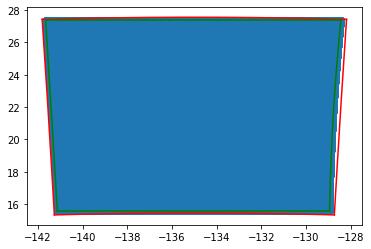

In [78]:
plt.scatter(LONI, LATI)
plt.plot(ds.lon_rho[:,0], ds.lat_rho[:,0], color='r')
plt.plot(ds.lon_rho[:,-1], ds.lat_rho[:,-1], color='r')
plt.plot(ds.lon_rho[0,:], ds.lat_rho[0,:], color='r')
plt.plot(ds.lon_rho[-1,:], ds.lat_rho[-1,:], color='r')

plt.plot(LONI[-1,:], LATI[-1,:], color='g')
plt.plot(LONI[0,:], LATI[0,:], color='g')
plt.plot(LONI[:,0], LATI[:,0], color='g')
plt.plot(LONI[:,-1], LATI[:,-1], color='g')


In [13]:
x[:,0].values

array([16411.668, 16412.066, 16412.463, 16412.861, 16413.258, 16413.652,
       16414.045, 16414.44 , 16414.834, 16415.225, 16415.613, 16416.006,
       16416.395, 16416.781, 16417.168, 16417.555, 16417.941, 16418.326,
       16418.71 , 16419.092, 16419.475, 16419.854, 16420.236, 16420.613,
       16420.992, 16421.37 , 16421.746, 16422.121, 16422.496, 16422.87 ,
       16423.246, 16423.613, 16423.988, 16424.355, 16424.729, 16425.096,
       16425.46 , 16425.828, 16426.193, 16426.562, 16426.924, 16427.287,
       16427.65 , 16428.01 , 16428.371, 16428.732, 16429.09 , 16429.447,
       16429.807, 16430.162, 16430.518, 16430.871, 16431.225, 16431.574,
       16431.926, 16432.28 , 16432.627, 16432.977, 16433.324, 16433.67 ,
       16434.02 , 16434.363, 16434.707, 16435.05 , 16435.395, 16435.732,
       16436.074, 16436.416, 16436.752, 16437.092, 16437.428, 16437.764,
       16438.102, 16438.436, 16438.77 , 16439.102, 16439.434, 16439.766,
       16440.092, 16440.422, 16440.75 , 16441.078, 

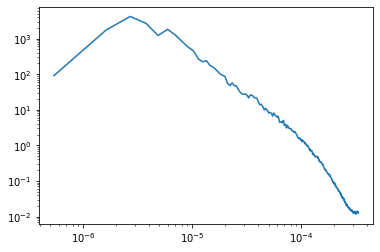

In [114]:
plt.loglog(ki, specke)

In [57]:
print(f'Mean Dx = {ds.dx.mean().values}')
print(f'Mean Dy = {ds.dy.mean().values}')

#Interpolate to uniform 1.5 km resolution
dx = 1500 

# This should be restricted to outside the sponge region (10 points around edges)
sponge = 10
latmin = np.max(ds.lat_rho[sponge, sponge:-sponge].values)
latmax = np.min(ds.lat_rho[-sponge,sponge:-sponge].values)
lonleft = np.max(ds.lon_rho[sponge:-sponge,sponge].values)
lonrght = np.min(ds.lon_rho[sponge:-sponge,-sponge].values)

a = 6371315.0 # CROCO Earth radius
m_per_deg = 2*np.pi*a/360

lats = np.arange(latmin, latmax, step=1.5e3/m_per_deg)


Mean Dx = 1497.1895751953125
Mean Dy = 1497.189208984375


In [163]:
xi.shape

(902,)

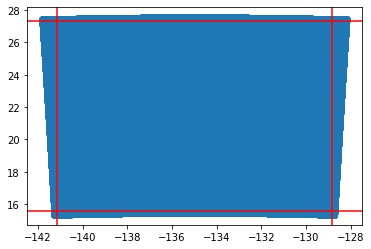

In [141]:
plt.scatter(ds.lon_rho, ds.lat_rho)
#plt.scatter(LONI, LATI, marker='x', c='r')
plt.axhline(latmin, color='r')
plt.axhline(latmax, color='r')
plt.axvline(lonleft, color='r')
plt.axvline(lonrght, color='r')

In [184]:
lons

array([[-141.25211346, -141.23812689, -141.22414033, ..., -128.70616252,
        -128.69217595, -128.67818938],
       [-141.25266188, -141.23867441, -141.22468694, ..., -128.70590104,
        -128.69191357, -128.6779261 ],
       [-141.25322556, -141.23923718, -141.22524881, ..., -128.70565403,
        -128.69166565, -128.67767728],
       ...,
       [-141.79530896, -141.78010802, -141.76490708, ..., -128.16006399,
        -128.14486305, -128.12966211],
       [-141.79596324, -141.78076044, -141.76555764, ..., -128.15904994,
        -128.14384713, -128.12864433],
       [-141.79663278, -141.78142811, -141.76622345, ..., -128.15804998,
        -128.14284531, -128.12764065]])

In [127]:
lontest = np.linspace(ds.lon_rho.min(), ds.lon_rho.max(), 50)
lattest = np.linspace(ds.lat_rho.min(), ds.lat_rho.max(), 20)
nx,ny = LONI.shape
tempcoarse = xroms.interpll(ds.temp.isel(ocean_time=-1, s_rho=slice(-2,-1)), LONI, LATI, which='')


ValueError: ('ocean_time', 's_rho', 'eta_rho', 'xi_rho') must be a permuted list of ('s_rho', 'eta_rho', 'xi_rho'), unless `...` is included

In [21]:
ui

,Array,Chunk
Bytes,8.90 GB,61.11 MB
Shape,"(91, 16, 877, 871)","(1, 10, 877, 871)"
Count,11581 Tasks,182 Chunks
Type,float64,numpy.ndarray


<ipython-input-26-6445d67fbfc5>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(ds.lon_rho, ds.lat_rho, ds.temp.isel(ocean_time=-1, s_rho=-1), vmin=22, vmax=27)


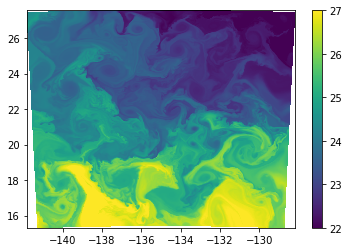

In [26]:
plt.pcolor(ds.lon_rho, ds.lat_rho, ds.temp.isel(ocean_time=-1, s_rho=-1), vmin=22, vmax=27)
plt.colorbar()

<ipython-input-80-8583c16f87c0>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(LONI, LATI, tempi.isel(yearday=-1, s_rho=-1), vmin=22, vmax=27)


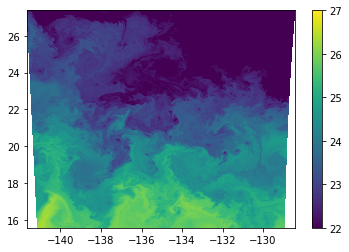

In [80]:
plt.pcolor(LONI, LATI, tempi.isel(yearday=-1, s_rho=-1), vmin=22, vmax=27)
plt.colorbar()

In [17]:
ds_out = xe.util.grid_2d(ds.lon_rho.min(), ds.lon_rho.max(),500/111e3, ds.lat_rho.min(), ds.lat_rho.max(), 500/111e3)

In [18]:
regridder = xe.Regridder(ds, ds_out, 'bilinear')
ds_new = regridder(ds)

ValueError: Receive multiple variables for key 'longitude': ['lon_rho', 'lon_v', 'lon_u']. Expected only one. Please pass a list ['longitude'] instead to get all variables matching 'longitude'.

In [117]:
from rasterio.warp import transform

ModuleNotFoundError: No module named 'rasterio'

In [284]:
def usqrt(u):
    return np.mean(u)

def usqrtslow(uvar):
    nspec = 0
    for yd in uvar.yearday.values:
        #print(yd)
        for j in uvar.s_rho.values:
            if nspec == 0:
                spec_ke = uvar.sel(s_rho=j, yearday=yd)
            else:
                spec_ke += uvar.sel(s_rho=j, yearday=yd)
            nspec += 1 # increment counter
    #print(spec_ke.shape)
    #print(nspec)
    temp = spec_ke/nspec
    return temp

In [450]:
#uvar = ui[0:2,zlim:,1:,1:]
#uvar = ds.u[0:2,zlim:,1:,1:]
#vvar = vi[0:2,zlim:,1:,1:]
dm = uvar.mean(['x','y','yearday', 's_rho']).values
print(f'Direct mean: {dm}')

if True:
    ufast = xr.apply_ufunc(np.mean, 
               uvar.load(), 
               input_core_dims=[['x','y']],
               #dask='parallelized',
               output_core_dims=[[]],
               #exclude_dims=set(['x', 'y'],),
               #output_dtypes=[np.float64],
               vectorize=True)
uslow = usqrtslow(uvar)
#fm = ufast.mean(['yearday','s_rho']).values
#print(f'UFUNC mean: {fm}')
sm = uslow.mean(['x','y']).values
#print(f'SLOW mean: {sm}')
dm = uvar.mean(['x','y','yearday', 's_rho']).values
print(f'Direct mean: {dm}')

Direct mean: -0.09428313189769613
Direct mean: -0.135731920990578


In [476]:
uvar = ui[0:2,zlim:,:,:]
dm = uvar.mean(['x','y','yearday', 's_rho']).values
print(f'Direct mean: {dm}')
uvar.load()
#uvar.compute()
#uslow = usqrtslow(uvar)

dm = uvar.mean(['x','y','yearday', 's_rho']).values
print(f'Direct mean: {dm}')



#dm = uvar.mean(['x','y','yearday', 's_rho']).values
#print(f'Direct mean: {dm}')

#dm = uvar.mean(['x','y','yearday', 's_rho']).values
#print(f'Direct mean: {dm}')


Direct mean: -0.05293544762358683
Direct mean: -0.05293544762358684


In [474]:
uvar

<xarray.DataArray 'u' (yearday: 2, s_rho: 2, y: 877, x: 871)>
array([[[[-1.26819855, -1.30015994, -1.34637788, ..., -0.50324976,
          -0.50241378, -0.50219023],
         [-1.26151482, -1.32746319, -1.39729045, ..., -0.51269786,
          -0.51106374, -0.5101633 ],
         [-1.34145797, -1.43105859, -1.50257428, ..., -0.52084528,
          -0.51874964, -0.51740002],
         ...,
         [-0.55463458, -0.54664358, -0.53980495, ..., -0.05887377,
          -0.05807242, -0.05756341],
         [-0.5363405 , -0.52891024, -0.52280948, ..., -0.06309181,
          -0.06266257, -0.0624917 ],
         [-0.51933256, -0.51238344, -0.50719852, ..., -0.06721953,
          -0.06750397, -0.06773424]],

        [[-0.33677819, -0.35128744, -0.3726885 , ..., -0.15655453,
          -0.15588622, -0.15524911],
         [-0.33205968, -0.36430303, -0.39805356, ..., -0.15913472,
          -0.15831279, -0.15755807],
         [-0.36620538, -0.41138015, -0.44707544, ..., -0.16117816,
          -0.1602643 , -0.15944257],
...
         [-0.11580901, -0.11451543, -0.11343466, ..., -0.00834329,
          -0.00830187, -0.00834663],
         [-0.11019605, -0.10924254, -0.10851691, ..., -0.00990824,
          -0.00994827, -0.01006172],
         [-0.10521392, -0.10458029, -0.10427296, ..., -0.0115242 ,
          -0.01173818, -0.01193688]],

        [[-0.32390849, -0.32611948, -0.32856262, ..., -0.10607489,
          -0.10634915, -0.10689054],
         [-0.32573334, -0.32758904, -0.32960614, ..., -0.10821359,
          -0.10821987, -0.10852036],
         [-0.33279294, -0.33359472, -0.334257  , ..., -0.11016075,
          -0.11001523, -0.11014393],
         ...,
         [-0.13715059, -0.13583738, -0.13472832, ..., -0.02494761,
          -0.02478663, -0.02473046],
         [-0.13149889, -0.13052351, -0.12976481, ..., -0.02645249,
          -0.02637315, -0.02637948],
         [-0.12653379, -0.12588309, -0.12554605, ..., -0.02799211,
          -0.0280865 , -0.02816647]]]])
Coordinates:
  * s_rho       (s_rho) float64 -0.01875 -0.00625
    ocean_time  (yearday) float64 2.696e+08 2.697e+08
  * yearday     (yearday) float64 240.0 241.0
    lon         (y, x) float64 -141.1 -141.1 -141.1 ... -128.5 -128.5 -128.4
    lat         (y, x) float64 15.57 15.57 15.57 15.57 ... 27.39 27.39 27.39
Dimensions without coordinates: y, x
Attributes:
    long_name:      u-momentum component
    units:          meter second-1
    field:          u-velocity, scalar, series
    standard_name:  sea_water_x_velocity_at_u_location
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...
    regrid_method:  bilinear